# Data cleaning and preparing

In [1]:
pip install jenkspy

     |████████████████████████████████| 55 kB 2.3 MB/s eta 0:00:011
  Created wheel for jenkspy: filename=jenkspy-0.2.0-cp37-cp37m-linux_x86_64.whl size=77793 sha256=ba69f632eb8a1677a8fc5e275e5d7f867669eace35e70a923fcdabca808b9cea
  Stored in directory: /home/jovyan/.cache/pip/wheels/d8/d1/42/9bd05164ef706b84674905892f0542f8db6ac4a652473ca7e0
Successfully built jenkspy
Note: you may need to restart the kernel to use updated packages.


In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, LineString, Polygon, shape
import math
import seaborn as sns
import requests
import json
import jenkspy
import matplotlib.pyplot as plt

In [3]:
lagos_grid  =  gpd.read_file("./data/lagos_grid.geojson", driver='GeoJSON')

## Competition - assign categorical values

<AxesSubplot:ylabel='Frequency'>

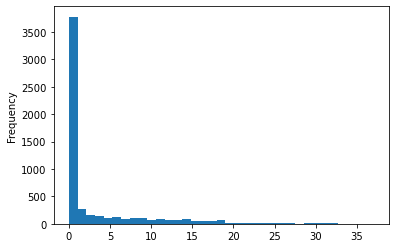

In [4]:
lagos_grid['competition_level'].plot.hist(bins=35)

In [5]:
lagos_grid['competition_level'] = lagos_grid['competition_level'].apply(lambda x : np.nan if x==0 else x)

In [6]:
### Using Jenks Natural Breaks

In [7]:
breaks = jenkspy.jenks_breaks(lagos_grid['competition_level'].dropna(), nb_class=5)

In [8]:
lagos_grid['competition_level_cat'] = pd.cut(lagos_grid['competition_level'],breaks,labels=['Very Low', 'Low','Medium','High','Very High'], include_lowest=True).astype(str)

In [9]:
lagos_grid['competition_level_cat'] = lagos_grid['competition_level_cat'].apply(lambda x : "None" if pd.isna(x) else x)

In [10]:
lagos_grid['competition_level_cat'].value_counts()

nan          3465
Very Low      894
Low           515
Medium        449
High          232
Very High      79
Name: competition_level_cat, dtype: int64

<AxesSubplot:xlabel='competition_level', ylabel='Count'>

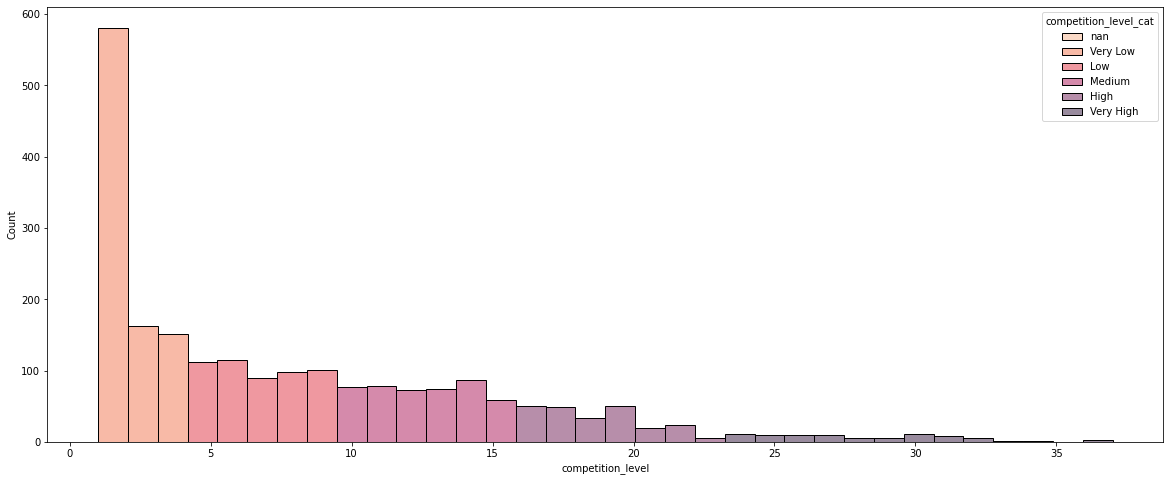

In [11]:
fig, ax = plt.subplots(figsize=(20,8))
sns.histplot(ax=ax, x='competition_level', data=lagos_grid, hue='competition_level_cat', bins=34, palette="rocket_r" )

<AxesSubplot:>

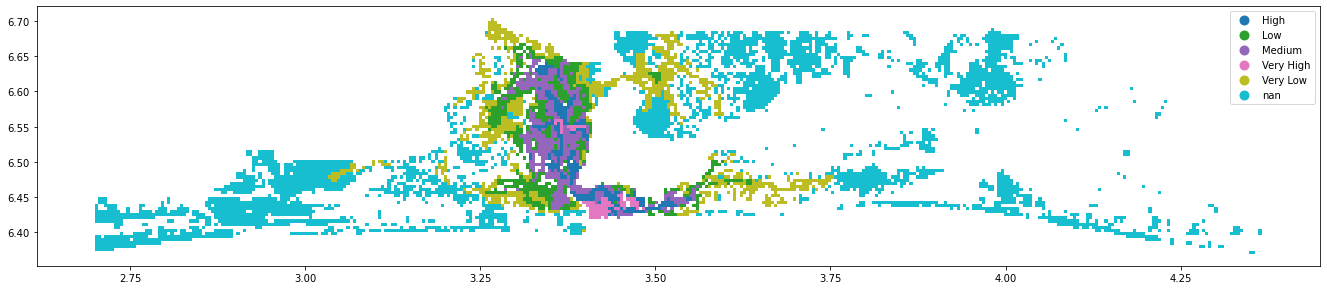

In [12]:
lagos_grid.plot(column="competition_level_cat", figsize=(23,7), legend=True)

## Wealth Level - assign categorical values

<AxesSubplot:ylabel='Frequency'>

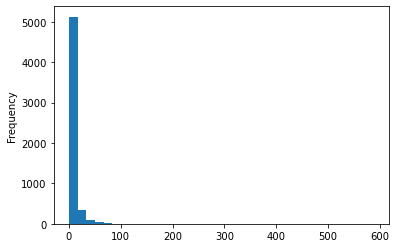

In [13]:
lagos_grid['light_mean'].plot.hist(bins=35)

<AxesSubplot:>

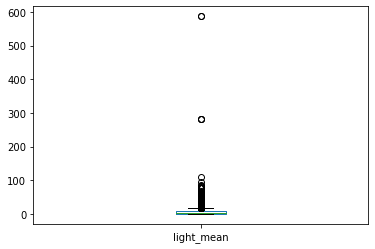

In [14]:
lagos_grid['light_mean'].plot.box()

In [15]:
## areas with more the 100 avg. light value needs to be rounded down - unrealistic values
lagos_grid['light_mean'] = lagos_grid['light_mean'].apply(lambda x : 60 if x > 300 else x )
lagos_grid['light_mean'] = lagos_grid['light_mean'].apply(lambda x : 90 if x > 100 else x )

<AxesSubplot:>

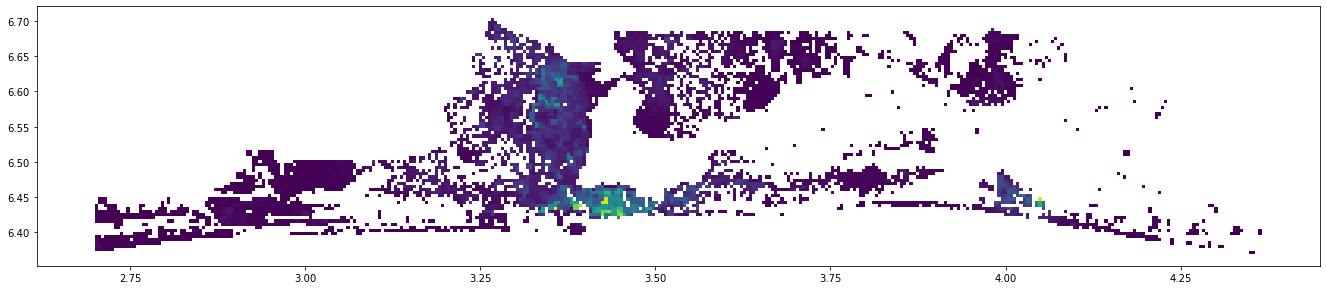

In [16]:
lagos_grid.plot(column="light_mean", figsize=(23,7))

In [17]:
### Using Jenks Natural Breaks

In [18]:
breaks = jenkspy.jenks_breaks(lagos_grid['light_mean'].dropna(), nb_class=5)

In [19]:
lagos_grid['light_mean_cat'] = pd.cut(lagos_grid['light_mean'],breaks,labels=['Very Low', 'Low','Medium','High','Very High'], include_lowest=True).astype(str)

In [20]:
#lagos_pop_grid['light_mean_cat'] = lagos_pop_grid['light_mean_cat'].apply(lambda x : "None" if pd.isna(x) else x)
lagos_grid['light_mean_cat'].value_counts()

Very Low     3672
Low          1359
Medium        435
High          146
Very High      22
Name: light_mean_cat, dtype: int64

In [21]:
bins = sorted(np.round(lagos_grid['light_mean']).unique())

<AxesSubplot:xlabel='light_mean', ylabel='Count'>

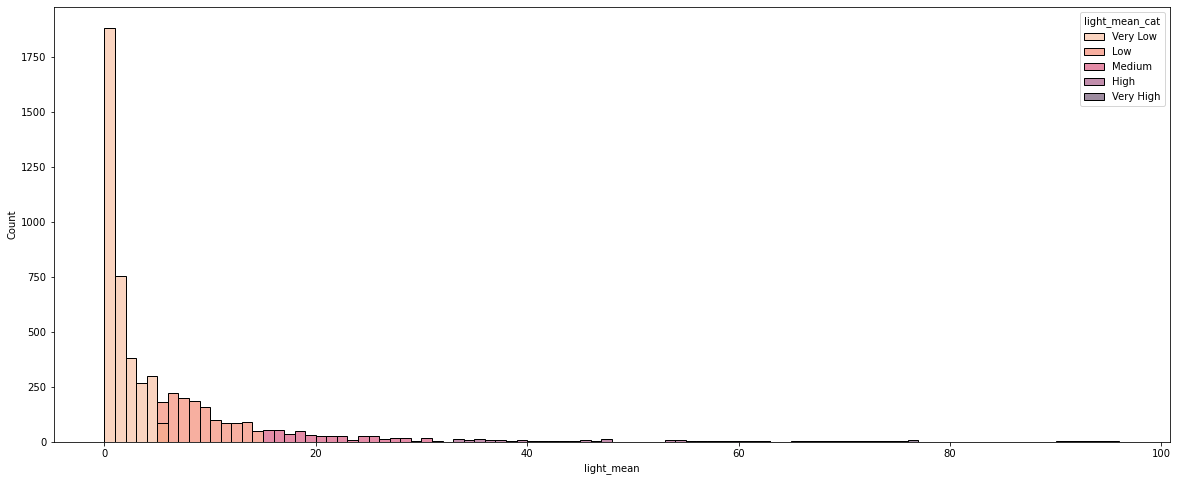

In [22]:
fig, ax = plt.subplots(figsize=(20,8))
sns.histplot(ax=ax, x='light_mean', data=lagos_grid, hue='light_mean_cat', palette="rocket_r", bins=bins)


<AxesSubplot:>

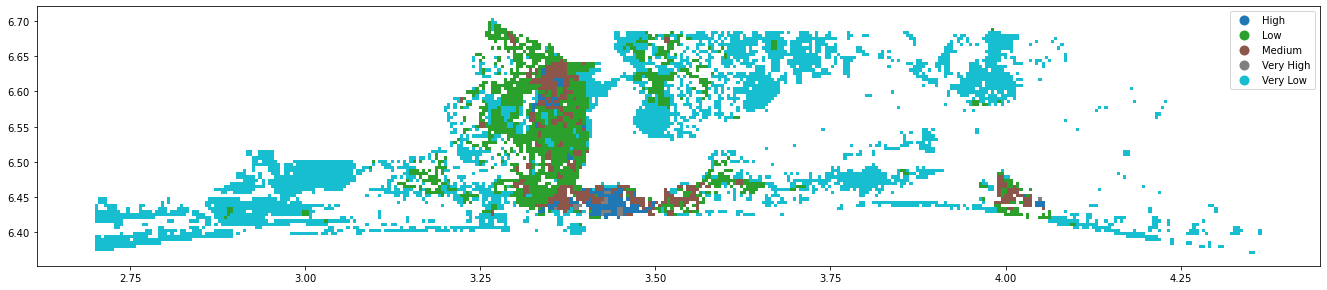

In [23]:
lagos_grid.plot(column="light_mean_cat", figsize=(23,7), legend=True)

## Save Final Grid File
prepared for the tool

In [24]:
lagos_grid.to_file("./final_data/lagos_grid.geojson", driver='GeoJSON')

---
## Lagos - Overview Data File

In [25]:
lagos_grid = gpd.read_file("./final_data/lagos_grid.geojson", driver='GeoJSON')
gdf_stores = gpd.read_file("./final_data/lagos_stores.geojson", driver='GeoJSON')

In [26]:
lagos_overview = {}

In [27]:
## Urban Level
lagos_overview['uban_level'] = lagos_grid.urban_level.mean()

In [28]:
## Population
lagos_overview['nga_general_2020'] = lagos_grid['nga_general_2020'].sum()

In [29]:
lagos_overview['nga_children_under_five_2020' ]= lagos_grid.nga_children_under_five_2020.sum()
lagos_overview['nga_youth_15_24_2020' ]= lagos_grid.nga_youth_15_24_2020.sum()
lagos_overview['nga_elderly_60_plus_2020']= lagos_grid.nga_elderly_60_plus_2020.sum()

In [30]:
## No stores 
lagos_overview['no_stores'] = gdf_stores['Store ID'].count()
lagos_overview['no_chains'] = gdf_stores['Brand Owner'].nunique()

In [31]:
## FLoorspace
lagos_overview['total_floorspace'] = gdf_stores['Floorspace'].sum()
lagos_overview['avg_floorspace']  = gdf_stores['Floorspace'].mean()

## Save
Lagos Overview Data for the tool

In [58]:
pd.DataFrame(data=lagos_overview, index=[0]).to_json( './final_data/lagos_overview.json' , orient="records")